# PIPELINE OVERVIEW
+ graph with genes as nodes and edges
+ generate a matrix from nodes based on specific parameters (features, random walk, shortest path..)
+ multidimensional matrices > embedding with tsne into 2D or 3D 
----------
+ Visualization typologies:
+ 2D PORTRAIT
+ 3D PORTRAIT
+ 3D LANDSCAPE
+ 3D SPHERE

In [2]:
#import bezier

from collections import (defaultdict,Counter)
from collections import defaultdict as dd
from collections import Counter as ct
from collections import OrderedDict
import colorsys
from colormap import rgb2hex, rgb2hls, hls2rgb
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from collections import Counter

from dosnes import dosnes

from fisher import pvalue
from fa2 import ForceAtlas2

import itertools as it

from matplotlib import colors as mcolors
import math
from math import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import mygene

import networkx as nx
from networkx.algorithms.flow import shortest_augmenting_path
from networkx.generators.degree_seq import expected_degree_graph
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np

import os
import os.path

import pandas as pd

import pickle
import plotly
import plotly.express as px
import plotly.graph_objs as pgo
import plotly.offline as py
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio

from prettytable import PrettyTable

import pylab

py.init_notebook_mode(connected = True)

#import pymysql as mysql

import random as rd

from scipy.spatial import distance_matrix
from scipy.spatial import distance
from scipy.cluster.hierarchy import fcluster
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from scipy.spatial import distance_matrix
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection,cluster)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import sys 

from tqdm import tqdm_notebook as tqdm
import time


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import umap 

----------------------------------------------

# SECTION FOR FUNCTIONS

### ANALYSIS FUNCTIONS

In [3]:
# alpha potentiell raus ?
# page rank methode
def rnd_walk_matrix2(A, r, a, num_nodes):

    num = 1*num_nodes
    n = num_nodes
    factor = float((1-a)/n)

    E = np.multiply(factor,np.ones([n,n]))              # prepare 2nd scaling term
    A_tele = np.multiply(a,A) + E  #     print(A_tele)
    M = normalize(A_tele, norm='l1', axis=0)                                 # column wise normalized MArkov matrix

    # mixture of Markov chains
    del A_tele
    del E

    U = np.identity(n,dtype=int) 
    H = (1-r)*M
    H1 = np.subtract(U,H)
    del U
    del M
    del H    

    W = r*np.linalg.inv(H1)   

    return W

### PLOTTING FUNCTIONS

+ Heatmap + Cluster from Matrix

In [4]:
'''
Generate a heatmap + Dendogramm from a Matrix.
Return plot.
'''
def heatmap_from_matrix(Matrix, title = None):

    # Dendogramm
    fig = pylab.figure(figsize=(12,8))

    axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
    Y = sch.linkage(Matrix, method='average')
    Z = sch.dendrogram(Y, orientation='left')
    axdendro.set_xticks([])
    axdendro.set_yticks([])


    # Plot distance 
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
    index = Z['leaves']
    Dsq = Matrix
    Dsq = Dsq[index,:]
    Dsq = Dsq[:,index]
    im = axmatrix.matshow(Dsq, aspect='auto', origin='lower')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])


    # Plot colorbar
    plt.title(title, fontsize= 20)
    axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    pylab.colorbar(im, cax=axcolor)
    
    plt.savefig('output_plots/' + title + '.png')

    
    return plt.show()

In [5]:
'''
Binning based on dict.
Return binned nodes.
'''
def bin_nodes(data_dict): 
    bins = set(data_dict.values())

    d_binned = {}
    for n in bins:
        d_binned[n] = [k for k in data_dict.keys() if data_dict[k] == n]
        
    return d_binned

+ Node Properties (color, size)

In [6]:
'''
Generate color list based on color count (i.e. nodes to be coloured).
Return list of colors.
'''
def coloring_nodes(n):
    colors = [colorsys.hsv_to_rgb(1.0/n*x,1,1) for x in range(n)]
    color_list = []
    for c in colors:
        cc = [int(y*255) for y in c]
        color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
        
    return color_list


'''
From generated colors, get lighter or darker subcategorical colors.
Return colors in light/dark version.
'''
def hex_to_rgb(hex):
     hex = hex.lstrip('#')
     hlen = len(hex)
     return tuple(int(hex[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))

def adjust_color_lightness(r, g, b, factor):
    h, l, s = rgb2hls(r / 255.0, g / 255.0, b / 255.0)
    l = max(min(l * factor, 1.0), 0.0)
    r, g, b = hls2rgb(h, l, s)
    return rgb2hex(int(r * 255), int(g * 255), int(b * 255))

def darken_color(r, g, b, factor=0.9):
    return adjust_color_lightness(r, g, b, 1 - factor)

+ 2D

In [7]:
'''
Dimensionality reduction from Matrix (t-SNE).
Return dict (keys: node IDs, values: x,y).
'''
def embed_tsne_2D(DM, prplxty, density, l_rate, steps, metric = 'precomputed'):
    
    tsne = TSNE(n_components = 2, random_state = 0, perplexity = prplxty, metric = metric,# init='pca',
                     early_exaggeration = density,  learning_rate = l_rate ,n_iter = steps)
    embed = tsne.fit_transform(DM)
    return embed



def get_posG(G,embed):
    posG = {}
    cc = 0
    for entz in G.nodes():
    #for entz in sorted(G.nodes()):
        posG[entz] = (embed[cc,0],embed[cc,1])
        cc += 1

    return posG

In [8]:
'''
Create Node Labels, based on a dict of coordinates (keys:node ID, values: x,y)
Return new dict of node iDs and features for each node.
'''
def labels2D(posG, feature_dict):
    labels = {} 
    c = 0
    for node, xy in sorted(posG.items(), key = lambda x: x[1][0]):
        labels[node] = ([node,feature_dict[node][0],feature_dict[node][1],feature_dict[node][2],feature_dict[node][3]])   
        c+=1
        
    return labels


'''
Create label position of coordinates dict.
Return new dict with label positions. 
'''
def position_labels(posG, move_x, move_y):
    posG_labels = {}
    for key,val in posG.items():
        xx = val[0] + move_x
        yy = val[1] + move_y
        posG_labels[key] = (xx,yy)
        
    return posG_labels

In [9]:
'''
Calculate the node degree from graph positions (dict).
Return list of radii for each node (2D). 
'''
def draw_node_degree(G, scalef):
    #x = 20
    #ring_frac = np.sqrt((x-1.)/x)
    #ring_frac = (x-1.)/x

    l_size = []
    for node in G.nodes():
        k = nx.degree(G, node)
        R = scalef * (1 + k**1.1)
        #r = ring_frac * R
      
        l_size.append(R)
    
    #l_k = [k/max(l_size) for k in l_size]
    
        
    return l_size

In [10]:
'''
Validation of Layouts 2D.
'''
def calc_dist_from_layout(posG):
    
    l_x= []
    l_y=[]
    for coords in posG.values():
            l_x.append(coords[0])
            l_y.append(coords[1])
            
    p_dist = []
    for idx,val in enumerate(l_x):
        d_list = []
        for c in range(len(l_x)):
            for yy in l_y:
                d = np.sqrt((l_x[idx]-l_x[c])**2+(l_y[idx]-l_y[c])**2)
            d_list.append(d)
        p_dist.append(d_list)
        
    return p_dist

In [11]:
''' 
Generate trace 2D.
Return trace. 
'''
def get_trace(x,y,trace_name,colour):
    trace = pgo.Scatter(name = trace_name,
    x = x,
    y = y,
    mode='markers',
    marker=dict(
        size=6,
        color=colour
    ),)
    return trace

+ 3D

In [12]:
# LANDSCAPE 

'''
From 2D embedded coordinates generate a 3D landscape by including the z-axis.
Return x,y,z coordinates, where z is set 0.
'''
def get_coords_landscape(posG):
    # IMPORTANT : sort pos by G.nodes()
    posG_sorted = dict([(key, posG[key]) for key in G.nodes()])

    df=pd.DataFrame(posG_sorted).T
    df['Z'] = 0*len(G.nodes())
    df.columns=['X','Y','Z']

    x=np.array(df['X'])
    y=np.array(df['Y'])
    z=np.array(df['Z'])

    return x,y,z


'''
Create trace of vertical connecting edges in between node z0 and node z=parameter (e.g.disease count).
Return trace with edges.
'''

def get_trace_edges_Z(x,y,z0,z):
    Xe = []
    for u in x:
        Xe += [u,u,None]

    Ye = []   
    for v in y:
        Ye += [v,v,None]  

    Ze = []  
    for w in z0:
        for t in z:
            Ze += [w,t,None]
            
    trace_edge = pgo.Scatter3d(
        x = Xe, 
        y = Ye, 
        z = Ze,
        mode = 'lines', hoverinfo='none',
        line = dict(width = 3.0, color = 'darkgrey'),
        opacity = 0.5
    )

    return trace_edge

'''
Create trace of nodes for x,y,z0 and x,y,z=parameter (e.g.disease count).
Return traces of nodes.
'''

def get_trace_nodes_Z(x,y,z0,z):
    
    trace_z0=pgo.Scatter3d(x=x,y=y,z=z0,
                             mode = 'markers',
                           text = list(feature_dict_sorted.items()),
                           hoverinfo = 'text',
                           textposition='middle center',
                           marker = dict(
                color = colours,
                size = size3d,
                symbol = 'circle',
            ),)

    trace_z=pgo.Scatter3d(x=x,y=y,z=z,
                             mode = 'markers',
                           #text = list(d_gene_dc_sorted.items()),
                           hoverinfo = 'text',
                           textposition='middle center',
                           marker = dict(
                color = colours,
                size = size3d,
                symbol = 'circle',
            ),)
    
    return trace_z0, trace_z

In [13]:
'''
Calculate the node degree from graph positions (dict).
Return list of radii for each node (3D). 
'''
def draw_node_degree_3D(G, scalef):
    x = 20
    ring_frac = (x-1.)/x

    l_size = []
    for node in G.nodes():
        k = nx.degree(G, node)
        R = scalef * (1+k**1.5)
        r = ring_frac * R
        l_size.append(r)
        
        l_size_n = []
        for i in l_size:
            j = np.sqrt(np.sqrt(i/max(l_size)))
            l_size_n.append(j*scalef)
        
    return l_size_n

In [14]:
'''
Dimensionality reduction from Matrix (t-SNE).
Return dict (keys: node IDs, values: x,y,z).
'''
def embed_tsne_3D(G, Matrix, prplxty, density, l_rate, n_iter):
    #prplxty = 10 # default = 30.
    #density = 20. # default 12.
    #l_rate = 100. # default 200.
    tsne3d = TSNE(n_components = 3, random_state = 0, perplexity = prplxty,
                     early_exaggeration = density,  learning_rate = l_rate, n_iter = n_iter)
    embed = tsne3d.fit_transform(Matrix)

    posG = {}
    cc = 0
    for entz in sorted(G.nodes()):
        posG[entz] = (embed[cc,0],embed[cc,1],embed[cc,2])
        cc += 1
        
    return posG

In [15]:
'''
Dimensionality reduction from Matrix (DOSNES - 3D sphere t-SNE).
Return dict (keys: node IDs, values: x,y,z).
'''
def embed_tsne_sphere(G, Matrix, metric = 'precomputed'):
    model = dosnes.DOSNES(metric = metric, random_state = 42, max_iter = 10, verbose = 1, learning_rate=1000)
    X_tsne_sphere = model.fit_transform(Matrix)

    posG = {}
    cc = 0
    for entz in sorted(G.nodes()):
        posG[entz] = (X_tsne_sphere[cc,0],X_tsne_sphere[cc,1], X_tsne_sphere[cc,2])
        cc += 1
    
    return posG

In [16]:
'''
Generates 3D coordinates from coloured communities (dict).
Return trace.
'''
def get_trace_nodes(G, posG, infolist, color_list, size):

    key_list=list(G.nodes())
    trace = pgo.Scatter3d(x=[posG[key_list[i]][0] for i in range(len(key_list))],
                           y=[posG[key_list[i]][1] for i in range(len(key_list))],
                           z=[posG[key_list[i]][2] for i in range(len(key_list))],
                           mode = 'markers',
                           text = infolist,
                           hoverinfo = 'text',
                           #textposition='middle center',
                           marker = dict(
                color = color_list,
                size = size,
                symbol = 'circle',
            ),
        )
    
    return trace

In [17]:
'''
Plot node features within 3D plot. 
Return trace.
'''
def get_node_features(posG, features):
    
    key_list=list(posG.keys())
    node_labels = pgo.Scatter3d(x=[posG[key_list[i]][0] for i in range(len(key_list))],
                               y=[posG[key_list[i]][1] for i in range(len(key_list))],
                               z=[posG[key_list[i]][2] for i in range(len(key_list))],
                                text = features,
                                mode='text', 
                                textfont=dict(
                                    size=10,
                                    color='silver'
                                ),
                                textposition='top center',
                                hoverinfo='none'
                               )
    return node_labels

In [18]:
'''
Generates edges from 3D coordinates.
Returns a trace of edges.
'''
def get_trace_edges(G, posG, color):
    Xe = []
    Ye = []
    Ze = []
    for e in G.edges():
        Xe += [posG[e[0]][0],posG[e[1]][0]]
        Ye += [posG[e[0]][1],posG[e[1]][1]]
        Ze += [posG[e[0]][2],posG[e[1]][2]]

    trace_edge = pgo.Scatter3d(
        x = Xe, 
        y = Ye, 
        z = Ze,
        mode = 'lines', hoverinfo='none',
        line = dict(width = 0.5, color = color),
        opacity = 0.3
    )

    return trace_edge

+ 3D: Sphere in background

In [19]:
'''
Generate a trace for 3D plotting a sphere (in the background) with chosen radius.
Return trace of sphere.
'''
def get_trace_sphere(r):
    n = 100j # resolution of sphere contours
    u, v = np.mgrid[0:pi:n, 0:2 * pi:n]

    x=r*np.cos(u)*np.sin(v) 
    y=r*np.sin(u)*np.sin(v) 
    z=r*np.cos(v) 

    sphere_trace = pgo.Surface(
                    x = x, 
                    y = y, 
                    z = z,
                    hoverinfo='skip',
                    contours = {'x': {'show':True, 'start':0, 'end':0, 'size':1, 'color' : 'lightgray'},
                                'y': {'show':True, 'start':0, 'end':0, 'size':1, 'color' : 'lightgray'},
                                'z': {'show':True, 'start':0, 'end':0, 'size':1, 'color' : 'lightgray'}
                               }
                    , showscale = False
                    , opacity = 0)
    return sphere_trace 

+ 3D: frame rotation

In [20]:
'''
Function to make 3D html plot rotating.
Returns frames, to be used in "pgo.Figure(frames = frames)"
'''
def rotate_z(x, y, z, theta):
    w = x+1j*y
    return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z 

### EXPORT FUNCTIONS
+ Coordinates export

In [21]:
def export_xyz_to_csv(posG, title):
    coords = pd.DataFrame(posG, index = ['X','Y','Z'], columns = nodes).T
    coords['Gene ID'] = genes_subset
    coords['Cluster ID'] = cluster_community
    
    return coords.to_csv(title +'.csv')

--------------------------------------------------------

# SUBDATASETS

### TEST GRAPHS | Bench marking 

In [22]:
# ZACHARYS KARATE NETWORK
#G_karate = nx.karate_club_graph()

# TREE GRAPH
#n = 200 # number of nodes
#r = n//(n//4) # branching factor
#G = nx.full_rary_tree(r, n)

# STAR GRAPH
#n = 200
#G = nx.star_graph(n)

# CYCLE GRAPH
#n = 200
#G = nx.cycle_graph(n)

# DRAW TEST GRAPH 
#nx.draw(G)

### PPI - DISEASE SUBGRAPH 

In [23]:
G_ppi = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}


# CHOOSE DISEASE CATEGORY 
disease_category = 'sarcoma'

l_disease_genes = []
for d_name in d_names_do.keys():
    if d_name.find(disease_category) != -1:
        #print(d_name,d_names_do[d_name])
        try:
            l_genes = d_do_genes[d_names_do[d_name]]
            for gene in l_genes:
                l_disease_genes.append(gene)
        except:
            #print(d_names_do[d_name],d_name)
                pass
set_disease_genes = set(l_disease_genes)
print('\nThere are %s genes found to be associated with "%s".' %(len(set_disease_genes),disease_category))

# SEARCH FOR SPECIFIC SUB-DISEASES WITH GENE ASSOCIATIONS

sub_categories = {}
for d_name in d_names_do.keys():
    if d_name.find(disease_category) != -1:
        try:
            sub_categories[d_name,d_names_do[d_name]]=len(d_do_genes[d_names_do[d_name]])
            #print('specific disease: %s (%s) ; # associated genes: %s' %(d_name,d_names_do[d_name],len(d_do_genes[d_names_do[d_name]])))
        except:
            pass

        
'''
# SPECIFY SUB CATEGORY OF DISEASE
spec = 'DOID:5093'

spec_nodes = []
for k,v in d_do_genes.items():
    if spec == k:
        spec_nodes = v

set_spec_nodes = set(spec_nodes)


# GRAPH 
G_sub = G_ppi.subgraph(set_spec_nodes)
G_sub_lcc = G_sub.subgraph(max(nx.connected_components(G_sub), key=len)) # largest connected component (lcc)
print('The lcc of the %s-sub PPI network contains %s genes.' %(disease_category,G_sub_lcc.number_of_nodes()))

G = G_sub_lcc

# Check which subcategory was chosen:
for k,v in sub_categories.items():
    if spec == k[1]:
        print(k,v)

'''

G_sub = G_ppi.subgraph(set_disease_genes)
G = G_sub.subgraph(max(nx.connected_components(G_sub), key=len)) # largest connected component (lcc)


There are 488 genes found to be associated with "sarcoma".


In [24]:
#d_gene_do # {'389289': ['DOID:11054', ..

In [25]:
#d_do_genes # {'DOID:11054': ['389289',...

In [26]:
#d_names_do # {'angiosarcoma':'DOID:0001816',...}

### PPI RANDOM SUBGRAPH

In [27]:
'''
G_ppi = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

# RANDOM SAMPLE 

N = 1000
rand_set = rd.sample(PPI.nodes(), N)

PPI_sub = nx.subgraph(PPI, rand_set)
G = PPI_sub.subgraph(max(nx.connected_components(PPI_sub), key=len))  # extract lcc graph

# test for network to only include lcc 
#print('Nodes within subgraph:', len(G.nodes()))
#nx.draw(G,pos=nx.spring_layout(G)
'''

"\nG_ppi = nx.read_edgelist('input/ppi_elist.txt',data=False)\n# d_ent_sym, d_sym_ent = genent2sym()\n\n# RANDOM SAMPLE \n\nN = 1000\nrand_set = rd.sample(PPI.nodes(), N)\n\nPPI_sub = nx.subgraph(PPI, rand_set)\nG = PPI_sub.subgraph(max(nx.connected_components(PPI_sub), key=len))  # extract lcc graph\n\n# test for network to only include lcc \n#print('Nodes within subgraph:', len(G.nodes()))\n#nx.draw(G,pos=nx.spring_layout(G)\n"

### YEAST PPI 

In [28]:
data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

Counter(data['Interaction Detection Method'])
Counter(data['Interaction Types'])

filter_score = data[(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') &
                    (data['Taxid Interactor A'] == "taxid:559292") & 
                    (data['Taxid Interactor B'] == "taxid:559292") ]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)

# ESSENTIAL GENES 
cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
essential_cere = cere_gene[(cere_gene['essentiality status'] == 'E')]
essential_genes_cere_list =  essential_cere['symbols'].tolist()

degree= dict(G_cere.degree())

mg = mygene.MyGeneInfo()
a = mg.querymany(essential_genes_cere_list, scopes='symbol', species=559292)
essential_genes_cere_names = pd.DataFrame.from_dict(a)
essential_genes_cere_entrez =  essential_genes_cere_names['entrezgene'].tolist()

cleaned_entrez_list = [x for x in essential_genes_cere_entrez if str(x) != 'nan']

degree_formatted={}
for k, v in degree.items():
    degree_formatted[k.replace("entrez gene/locuslink:","")] = v
    
index= []
essential = []
for i in cleaned_entrez_list:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            essential.append(val)  

no_essential_cere = cere_gene[(cere_gene['essentiality status'] == 'NE')]
no_essential_genes_cere_list =  no_essential_cere['symbols'].tolist()
b = mg.querymany(no_essential_genes_cere_list, scopes='symbol', species=559292)
no_essential_genes_cere_names = pd.DataFrame.from_dict(b)
no_essential_genes_cere_entrez =  no_essential_genes_cere_names['entrezgene'].tolist()
cleaned_entrez_list_no = [x for x in no_essential_genes_cere_entrez if str(x) != 'nan']

index= []
no_essential = []
for i in cleaned_entrez_list_no:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            no_essential.append(val)
            
df_cere = pd.DataFrame({'essential': pd.Series(essential), 'no_essential': pd.Series(no_essential)})

querying 1-1000...done.
querying 1001-1037...done.
Finished.
15 input query terms found no hit:
	['nan', 'YGR251W', 'YHR122W', 'TID3', 'YJR141W', 'YLR099W-A', 'MDN1', 'YLR132C', 'YLR243W', 'YMR134W
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4543...done.
Finished.
1 input query terms found dup hits:
	[('IMP2', 2)]
311 input query terms found no hit:
	['FLP1', 'REP1', 'RAF1', 'REP2', 'YAL018C', 'YAL044W-A', 'AIM1', 'YAL064C-A', 'YBL010C', 'YBL059W', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [29]:
no_essential_genes_cere_names

,query,_id,_score,entrezgene,name,symbol,taxid,notfound
0,COX1,854598,40.009310,854598,cytochrome c oxidase subunit 1,COX1,559292.0,NaN
1,AI1,854593,76.088750,854593,intron-encoded reverse transcriptase aI1,AI1,559292.0,NaN
2,AI2,854594,74.399475,854594,intron-encoded reverse transcriptase aI2,AI2,559292.0,NaN
3,AI3,854595,74.399086,854595,intron-encoded DNA endonuclease aI3,AI3,559292.0,NaN
4,AI4,854596,76.088326,854596,intron-encoded DNA endonuclease aI4,AI4,559292.0,NaN
...,...,...,...,...,...,...,...,...
4538,YPR196W,856326,76.086170,856326,putative maltose-responsive transcription factor,YPR196W,559292.0,NaN
4539,SGE1,856327,74.403770,856327,Sge1p,SGE1,559292.0,NaN
4540,ARR1,856329,78.640300,856329,Arr1p,ARR1,559292.0,NaN
4541,ARR2,856330,76.088326,856330,Arr2p,ARR2,559292.0,NaN


In [30]:
essential_genes_cere_names

,query,_id,_score,entrezgene,name,symbol,taxid,notfound
0,TFC3,851262,78.642456,851262,transcription factor TFIIIC subunit TFC3,TFC3,559292.0,NaN
1,EFB1,851260,72.143880,851260,translation elongation factor 1 subunit beta,EFB1,559292.0,NaN
2,MAK16,851208,55.803380,851208,ribosome biosynthesis protein MAK16,MAK16,559292.0,NaN
3,PRP45,851201,68.458470,851201,mRNA splicing protein PRP45,PRP45,559292.0,NaN
4,POP5,851200,55.599960,851200,RNA-binding protein POP5,POP5,559292.0,NaN
...,...,...,...,...,...,...,...,...
1032,SMX3,856312,78.640260,856312,mRNA splicing protein SMX3,SMX3,559292.0,NaN
1033,DPM1,856313,56.161957,856313,dolichyl-phosphate beta-D-mannosyltransferase,DPM1,559292.0,NaN
1034,PZF1,856316,73.142900,856316,Pzf1p,PZF1,559292.0,NaN
1035,RPO26,856317,76.088326,856317,DNA-directed RNA polymerase core subunit RPO26,RPO26,559292.0,NaN


In [31]:
no_ess_id = no_essential_genes_cere_names['entrezgene']
ess_id = essential_genes_cere_names['entrezgene']

G = G_cere

# GRAPH PROPERTIES

In [32]:
degs = dict(G.degree())
#nodes = list(G.nodes())
#edges = list(G.edges())
#n_nodes = len(list(G.nodes()))
#nx.draw(G,pos=nx.spring_layout(G))
        
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 5995
Number of edges: 107919
Network density: 0.6%


#### Degree Distribution 

Degree min: 1
Degree max: 3605
Degree Mean: 36.003002502085074
Degree Variant: 10688.79165070141


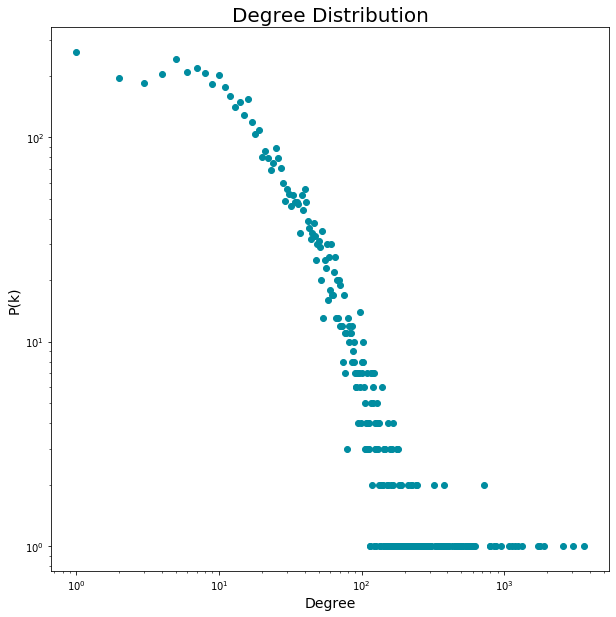

In [33]:
l_k = list(degs.values())
set_k = set(l_k)
print('Degree min:', min(l_k))
print('Degree max:', max(l_k))

d_k_f = {}
for k in set_k:
    d_k_f[k] = l_k.count(k)
#print('Degree counts:',d_k_f)

mean_deg = np.mean(l_k)
var_deg = np.var(l_k)
print('Degree Mean:', mean_deg)
print('Degree Variant:', var_deg)

plt.figure(figsize=(10,10))
plt.title('Degree Distribution', fontsize = 20)
plt.xlabel('Degree', fontsize = 14)
plt.ylabel('P(k)', fontsize = 14)
plt.loglog(list(d_k_f.keys()),list(d_k_f.values()),'o',c='#008CA0')
plt.show()

#plt.savefig('PPIdegreedist.png')

# FEATURE COLLECTION - Topological+Functional

#### + TOPOLOGICAL FEATURES
##### based on: https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html
+ degree centrality
+ closeness centrality
+ betweeness centrality
+ eigenvector centrality


+ HUBS: "importance" score if considered hub and direct hub-adjacent
+ PERIPHERAL HUBS ("Distinctiveness Centrality") (resource: https://towardsdatascience.com/distinctiveness-centrality-56c1e6762328)
___
#### + BIOLOGICAL FEATURES (functional parameters) ??? 
___

# WORK IN PROGRESS : Add functional parameters to feature collection?!

#### DEGREE CENTRALITY
+ Node degree: important nodes being involved within high number of interactions

In [34]:
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)

#### CLOSENESS CENTRALITY
+ Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes

In [35]:
%%time 
closeness = nx.closeness_centrality(G)

KeyboardInterrupt: 

In [108]:
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)

#### BETWEENESS CENTRALITY 
+ How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network

In [102]:
%%time 
betweens = nx.betweenness_centrality(G)

KeyboardInterrupt: 

In [78]:
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)

#### EIGENVECTOR CENTRALITY 
+ Compute the eigenvector centrality for the graph

In [79]:
eigen = nx.eigenvector_centrality(G)

In [80]:
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)

#### HUB considered nodes + adjacent nodes
+ additional parameter to emphasize importance of nodes

In [81]:
cutoff = 10 # select how many "important" nodes based on centrality to choose from

d_deghubs_cutoff = {}
for node, de in sorted(degs.items(), key = lambda x: x[1], reverse = 1)[:cutoff]:
#     print('node %s: degree=%s' %(node,1.*de/max(degs.values())))
    d_deghubs_cutoff[node] = de/max(degs.values())
    
d_closhubs_cutoff = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1)[:cutoff]:
#     print('node %s: closeness=%s' %(node,cl))
    d_closhubs_cutoff[node] = cl

d_betwhubs_cutoff = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1)[:cutoff]:
#     print('node %s: betweeness=%s' %(node,be))
    d_betwhubs_cutoff[node] = be

In [83]:
overlap = set(d_deghubs_cutoff.keys()) & set(d_closhubs_cutoff.keys()) & set(d_betwhubs_cutoff.keys())
d_node_score = {}
for node in overlap:
    d_node_score[node] = d_deghubs_cutoff[node]+d_betwhubs_cutoff[node]+d_closhubs_cutoff[node]
       
print('most important ', len(overlap), ' nodes in network by degree and centrality')    
for a,b in sorted(d_node_score.items(), key = lambda x: x[1], reverse = 1):
    print(a,b)

# Assign "centrality independent" score to hubs and their adjacent nodes 
d_hubs = {}
c = 1
for nd,score in d_node_score.items():
    for node in G.nodes():
        if nd == node:
            d_hubs[node] = c
            c+=1

direct_neigh = {}
for n in d_hubs.keys():
    l = []
    for pair in G.edges():
        if n == pair[0]:
            l.append(pair[1])
            direct_neigh[n] = l
        elif n == pair[1]:
            l.append(pair[0])
            direct_neigh[n] = l

d_hubsneigh = {}
for node,score in d_hubs.items():
    for nd,neigh in direct_neigh.items():
        for n in neigh:
                if node==nd and n not in d_hubs.keys():
                    d_hubsneigh[n] = score

d_hubs_inclneigh = {**d_hubs,**d_hubsneigh}

d_no_hubs = {}
for i in G.nodes():
    if i not in d_hubs_inclneigh.keys():
        d_no_hubs[i] = 0
        
d_hubscored = {**d_no_hubs,**d_hubs_inclneigh}

most important  8  nodes in network by degree and centrality
4914 1.612611840284705
1956 1.466631376250269
7157 1.3799204530134621
3725 1.3306712577246058
4193 1.3004296731464837
4609 1.1697776825843285
207 1.1007754432502765
6714 1.0914068484493231


#### PERIPHERAL HUB considered nodes + adjacent nodes
+ adding node importance to peripheral hubs, which are the only connection to a certain bunch of peripheral nodes
+ maybe referred to as Distinctiveness Centrality

In [84]:
from distinctiveness.dc import dc_all

#Calculate the 5 metrics of Distinctiveness Centrality
distinct_central = dc_all(G, normalize = True, alpha = 1)
distinct_central = pd.DataFrame(distinct_central).sort_index()

d_distinctiveness = dict(distinct_central['D2']) # D2 for not considering arc weight

ModuleNotFoundError: No module named 'distinctiveness'

### Complete FEATURE COLLECTION

In [86]:
# same order of node IDs for all features

d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}
d_hubscored_sorted = {key:d_hubscored[key] for key in sorted(d_hubscored.keys())}
#d_distinct_sorted = {key:d_distinctiveness[key] for key in sorted(d_distinctiveness.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                     d_hubscored_sorted.values(),
                                                    #d_distinct_sorted.values()
                                                    )))

# IMPORTANT : sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen', 
                                                                                      'hub score',
                                                                                      #'distinctiveness'
                                                                                      ]) 


l_features = [] 
for i in feature_dict_sorted.items():
    k = list(i)
    l_features.append(k)

In [87]:
feature_df.head()

,degs,clos,betw,eigen,hub score
57731,0.0238,0.3154,0.0000,0.0082,0
3945,0.2262,0.3990,0.0046,0.0792,6
25844,0.0357,0.2907,0.0097,0.0032,0
4792,0.1548,0.3806,0.0055,0.0506,8
2335,0.6310,0.4382,0.0669,0.1515,7


In [88]:
feature_df_ascend = feature_df.sort_values(by=['degs'], ascending=False)

In [89]:
feature_df_ascend

,degs,clos,betw,eigen,hub score
4914,1.0000,0.4724,0.1402,0.2042,2
1956,0.8690,0.4681,0.1295,0.1756,1
7157,0.8452,0.4587,0.0760,0.2348,3
3725,0.8214,0.4410,0.0683,0.2186,6
4193,0.7738,0.4516,0.0750,0.2169,5
...,...,...,...,...,...
9401,0.0119,0.3040,0.0000,0.0073,0
10102,0.0119,0.2502,0.0000,0.0010,0
3458,0.0119,0.2495,0.0000,0.0005,0
8242,0.0119,0.2420,0.0000,0.0006,0


# MATRICES
+ matrix 1-4 are based on Graph Features, calculating shortest paths / random walks
+ matrix 5-8 are based on Feature Collection, calculation pairwise distances, due to similiarities of nodes

In [92]:
%%time 

# dict of index:node ID
d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1

Mspl = np.zeros(len(list(G.nodes())))

for n1 in range(len(list(G.nodes()))):
    vec = []
    for n2 in range(len(list(G.nodes()))):
        geneA = d_idx_entz[n1]
        geneB = d_idx_entz[n2]
        try:
            spl = nx.shortest_path_length(G,geneA,geneB)
            vec.append(spl)
        except nx.NetworkXNoPath:
            print('no path')
        
    Mspl = np.vstack((Mspl,vec))
Mspl = np.delete(Mspl, (0), axis=0)  

CPU times: user 40 s, sys: 3.63 ms, total: 40 s
Wall time: 40 s


In [93]:
%%time 

# Restart probability
r = .8 # originally 0.8

alpha = 1.0 # indicating "randomness" - originally 1.
# Community lastig --> teleportationsmöglichkeit alpha
# = Freiheitsgrad 

# adjacency matrix
A = nx.adjacency_matrix(G)
DM_adj = A.toarray()

# SPL MATRIX
DM_spl = Mspl 

# invert Markov (random walk)
DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
DM_m_mod = np.array([(1-(x/max(x))) for x in DM_m])

# -log(Markov) matrix
min_log = lambda t: -np.log(t)
DM_mlog = np.array([min_log(x/max(x)) for x in DM_m])

# scipy "pdist" for distance
DM_cos = distance.squareform(distance.pdist(feature_df, 'cosine'))
DM_eucl = distance.squareform(distance.pdist(feature_df, 'euclidean'))
DM_sqeucl = distance.squareform(distance.pdist(feature_df, 'sqeuclidean'))
DM_corr = distance.squareform(distance.pdist(feature_df, 'correlation'))

CPU times: user 356 ms, sys: 775 ms, total: 1.13 s
Wall time: 230 ms


# NODE COLOURS

### COLOURING ESSENTIALITY (Yeast PPI) 

In [94]:
no_ess_col = 'lightsteelblue'
ess_col = 'mediumblue'
rest = 'lightgrey'

d_ess = {}
for node in no_ess_id:
    d_ess[node] = ess_col
d_no_ess = {}
for node in ess_id:
    d_no_ess = no_ess_col
    
d_essentiality = {**d_ess, **d_no_ess}

TypeError: 'str' object is not a mapping

In [ ]:
d_restnodes = {}
for node in G.nodes():
    if node not in d_essentiality.keys():
        d_restnodes[node] = rest

In [ ]:
d_all_essentiality = {**d_essentiality, **d_restnodes}

### COLOURING DISTINCTIVENESS CENTRALITY (i.e. topological property)

In [ ]:
# WORK IN PROGRESS : WRITE FUNCTION 
# colouring a DICT of nodes:scores + colouring the adjacent nodes of such

In [ ]:
cutoff = 5 # select how many "important" nodes based on centrality to choose from

d_distinctiveness_cutoff = {}
for node, d in sorted(distinctiveness.items(), key = lambda x: x[1], reverse = 1)[:cutoff]:
    d_distinctiveness_cutoff[node] = d/max(distinctiveness.values())
    
# CREATE COLORS based on amount required
n = len(d_distinctiveness_cutoff)
color = coloring_nodes(n)
sns.palplot(color)

# LIGHTER COLORS for e.g. NEIGHBOURING NODES
factor = 1.7 # the higher the lighter
color_neigh = []
for i in color:
    r,g,b = hex_to_rgb(i)
    color_light = adjust_color_lightness(r,g,b,factor)
    color_neigh.append(color_light)

sns.palplot(color_neigh)


# ------------------------------------------------------
# DISTINCTIVENESS: NODES


# distinctiveness (peripheral hubs) coloured
d_col_distinct = {}
for idx,n in enumerate(d_distinctiveness_cutoff.keys()):
        d_col_distinct[n] = color[idx]
        
direct_neigh = {}
for n in d_col_distinct.keys():
    l = []
    for pair in G.edges():
        if n == pair[0]:
            l.append(pair[1])
            direct_neigh[n] = l
        elif n == pair[1]:
            l.append(pair[0])
            direct_neigh[n] = l

d_col_neigh = {}
for node,col in d_col_distinct.items():
    for idx, node in enumerate(d_col_distinct.keys()):
        for nd,neigh in direct_neigh.items():
            for n in neigh:
                if node==nd and n not in d_col_distinct.keys():
                    d_col_neigh[n]=color_neigh[idx]

d_col = {**d_col_distinct,**d_col_neigh}

# nodes with no connection to hub 
d_grey = {}
for i in G.nodes():
    if i not in d_col.keys():
        d_grey[i] = 'snow'

d_col_all = {**d_col_distinct, **d_col_neigh, **d_grey}
d_col_all_sorted = {key:d_col_all[key] for key in G.nodes()}

l_col_distinct = list(d_col_all_sorted.values())

colours = l_col_distinct # NODE COLOURING based on HUBS
#sns.palplot(l_col_distinct)


# ------------------------------------------------------
# DISTINCTIVENESS: EDGES 

# Hub outgoing edges
edge_lst = []
for edge in G.edges():
    for e in edge:
        for node in d_col_distinct.keys():
            if e == node:
                edge_lst.append(edge)
                
# Color edges based on hubs
d_col_edges = {}
for e in edge_lst:
    for node,col in d_col_distinct.items():
        if e[0] == node:
            d_col_edges[e]=col
        elif e[1] == node:
            d_col_edges[e]=col

sns.palplot(list(d_col_edges.values()))

d_grey_edges = {}
for edge in G.edges():
    if edge not in d_col_edges.keys(): 
        d_grey_edges[edge] = 'silver'
        
d_edges_all = {**d_col_edges, **d_grey_edges}

# Sort according to G.edges()
d_edges_all_sorted = {key:d_edges_all[key] for key in G.edges()}

edge_color = list(d_edges_all_sorted.values())

### COLOURING HUBS (i.e. topological property

In [ ]:
n = len(overlap)
color = coloring_nodes(n)
sns.palplot(color)

# LIGHTER COLORS FOR NEIGHBOURING NODES
factor = 1.7 # the higher the lighter
color_neigh = []
for i in color:
    r,g,b = hex_to_rgb(i)
    color_light = adjust_color_lightness(r,g,b,factor)
    color_neigh.append(color_light)

sns.palplot(color_neigh)

# ------------------------------------------------------
# HUBS: NODES 

# Hubs coloured
d_col_hubs = {}
for idx,n in enumerate(d_node_score.keys()):
        d_col_hubs[n] = color[idx]
        
direct_neigh = {}
for n in d_col_hubs.keys():
    l = []
    for pair in G.edges():
        if n == pair[0]:
            l.append(pair[1])
            direct_neigh[n] = l
        elif n == pair[1]:
            l.append(pair[0])
            direct_neigh[n] = l

d_col_neigh = {}
for node,col in d_col_hubs.items():
    for idx, node in enumerate(d_col_hubs.keys()):
        for nd,neigh in direct_neigh.items():
            for n in neigh:
                if node==nd and n not in d_col_hubs.keys():
                    d_col_neigh[n]=color_neigh[idx]

d_col = {**d_col_hubs,**d_col_neigh}

# nodes with no connection to hub 
d_grey = {}
for i in G.nodes():
    if i not in d_col.keys():
        d_grey[i] = 'lightgrey'

d_col_all = {**d_col_hubs, **d_col_neigh, **d_grey}
d_col_all_sorted = {key:d_col_all[key] for key in G.nodes()}

l_col_hubs = list(d_col_all_sorted.values())

colours = l_col_hubs # NODE COLOURING based on HUBS
#sns.palplot(l_col_hubs)

# ------------------------------------------------------
# HUBS: EDGES 

# Hub outgoing edges
edge_lst = []
for edge in G.edges():
    for e in edge:
        for node in d_col_hubs.keys():
            if e == node:
                edge_lst.append(edge)
                
# Color edges based on hubs
d_col_edges = {}
for e in edge_lst:
    for node,col in d_col_hubs.items():
        if e[0] == node:
            d_col_edges[e]=col
        elif e[1] == node:
            d_col_edges[e]=col

sns.palplot(list(d_col_edges.values()))

d_grey_edges = {}
for edge in G.edges():
    if edge not in d_col_edges.keys(): 
        d_grey_edges[edge] = 'lightgrey'
        
d_edges_all = {**d_col_edges, **d_grey_edges}

# Sort according to G.edges()
d_edges_all_sorted = {key:d_edges_all[key] for key in G.edges()}

edge_color = list(d_edges_all_sorted.values())

### COLOURING SUBCATEGORIES e.g. Disease subcategory (i.e. functional property)

In [ ]:
# input = dict

n = len(sub_categories)
colors = coloring_nodes(n)

doid_coloured = {}
c=0
for k,v in sub_categories.items():
    doid_coloured[k[1]]=colors[c]
    c+=1
    
d_gene_colours = {}
for doid, gene in d_do_genes.items(): 
    for i in gene:
        for do, col in doid_coloured.items():
            if doid == do:
                d_gene_colours[i]=col

# SORT dict based on G.nodes
d_gene_colours_sorted = {key:d_gene_colours[key] for key in G.nodes()}

l_col_subcat = list(d_gene_colours_sorted.values())
colours = l_col_subcat # NODE COLOURING based on Subcategory
edge_color = 'lightgrey'

sns.palplot(l_col_subcat)

### COLOURING CLOSENESS CENTRALITY (i.e. topological property)

In [ ]:
# Define colour parameter
d_to_be_coloured = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
palette = sns.color_palette('Reds', colour_count)

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
            
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())
colours = l_col_clos # NODE COLOURING based on Closeness Centrality
edge_color = 'lightgrey'

sns.palplot(l_col_clos)

----------------------------------------------
# LAYOUTS

In [ ]:
node_factor = 1.0
size = draw_node_degree(G, node_factor) # node size based on degree

opacity_nodes = 1.0
opacity_edges = 0.5
fontsize_labels = 12

# 2D Organic spring 

In [ ]:
forceatlas2 = ForceAtlas2()
#posG_spring = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)
posG_spring = nx.spring_layout(G)

plt.figure(figsize=(18,18))
plt.title('Organic spring', size=16)
plt.xlabel('x - axis', fontsize=16)
plt.ylabel('y - axis', fontsize=16)

nx.draw_networkx_nodes(G, posG_spring,
                       edgecolors = 'k', 
                       linewidths = 0.5, 
                       node_color=colours, node_size=size)
nx.draw_networkx_edges(G, pos = posG_spring, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_spring, font_size = fontsize_labels, font_color = 'black')

print('Number of Nodes:', len(G.nodes()))
#print('Colours: Hubs')
#print('Node Size: Disease association count')

plt.savefig('output_plots/Organic_spring_layout2D_.png')
plt.show()

# 2D PORTRAITS | 2D t-SNE

In [ ]:
# EMBEDDING 

prplxty = 50 # range: 5-50 / default = 30.
density = 1.  # default 12.
l_rate = 200 # default 200.
steps = 250 # min 250


# Adjacency Matrix
embed_adj = embed_tsne_2D(DM_adj, prplxty, density, l_rate, steps)
posG_adj = get_posG(G,embed_adj)

# SPL Matrix 
embed_spl = embed_tsne_2D(DM_spl, prplxty, density, l_rate, steps)
posG_spl = get_posG(G,embed_spl)

# Markov Matrix
embed_m = embed_tsne_2D(DM_m, prplxty, density, l_rate, steps)
posG_m = get_posG(G,embed_m)
embed_m_mod = embed_tsne_2D(DM_m_mod, prplxty, density, l_rate, steps)
posG_m_mod = get_posG(G,embed_m_mod)

# Markov -log Matrix 
embed_mlog = embed_tsne_2D(DM_mlog, prplxty, density, l_rate, steps)
posG_mlog =get_posG(G,embed_mlog)


# Distance Matrices based on pdist
# cosine
embed_cos = embed_tsne_2D(DM_cos, prplxty, density, l_rate, steps)
posG_cos = get_posG(G,embed_cos)

# euclidean
embed_eucl = embed_tsne_2D(DM_eucl, prplxty, density, l_rate, steps)
posG_eucl = get_posG(G,embed_eucl)

# squared euclidean
embed_sqeucl = embed_tsne_2D(DM_sqeucl, prplxty, density, l_rate, steps)
posG_sqeucl = get_posG(G,embed_sqeucl)

# Correlation Pairwise Matrix
embed_corr = embed_tsne_2D(DM_corr, prplxty, density, l_rate, steps)
posG_corr = get_posG(G,embed_corr)

In [ ]:
print('Number of nodes:', len(G.nodes()))
print('')
print('Perplexity:', prplxty)
print('Early Exaggeration:', density)
print('Learning rate:', l_rate)
print('Iterations:', steps)


plt.figure(figsize=(25,25))

plt.subplot(441)
plt.title('Adjacency + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')

nx.draw_networkx_nodes(G, posG_adj, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_adj, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_nodes(G, posG_adj_mod, node_color=colours, node_size=size, alpha = opacity_nodes)
#nx.draw_networkx_edges(G, pos = posG_adj_mod, width = 1., edge_color = 'lightgrey', alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_adj, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(442)
plt.title('Shortest Path length + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')

nx.draw_networkx_nodes(G, posG_spl, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_spl, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_spl, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(443)
plt.title('Markov + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

#nx.draw_networkx_nodes(G, posG_m, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
#nx.draw_networkx_edges(G, pos = posG_m, width = 1., edge_color = 'lightgrey', alpha = opacity_edges)
nx.draw_networkx_nodes(G, posG_m_mod, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_m_mod, width = 1., edge_color = edge_color, alpha = opacity_edges)

#nx.draw_networkx_labels(G, pos = posG_m, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.subplot(444)
plt.title('-log Markov + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')

nx.draw_networkx_nodes(G, posG_mlog, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_mlog, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_mlog, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/matrices_4x4_01.png')
plt.show()


# 4 Plots
plt.figure(figsize=(25,25))

plt.subplot(441)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Cosine + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_cos, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_cos, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_cos, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(442)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Euclidean + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_eucl, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_eucl, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_eucl, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(443)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Squared euclidean + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_sqeucl, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_sqeucl, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_sqeucl, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(444)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('Correlation matrix + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_corr, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size)#, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_corr, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_corr, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/matrices_4x4_2.png')
plt.show()

In [ ]:
plt.figure(figsize=(25,25))

plt.title('Adjacency + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')

nx.draw_networkx_nodes(G, posG_adj, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_adj, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_nodes(G, posG_adj_mod, node_color=colours, node_size=size, alpha = opacity_nodes)
#nx.draw_networkx_edges(G, pos = posG_adj_mod, width = 1., edge_color = 'lightgrey', alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_adj, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_adj.png')

plt.show()

In [ ]:
plt.figure(figsize=(25,25))
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Squared euclidean + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_sqeucl, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_sqeucl, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_sqeucl, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_sqeucl.png')

plt.show()

# THE LANDSCAPES | 2D t-SNE + Z 

In [ ]:
d_distinct_sort = {key:d_distinctiveness[key] for key in G.nodes()}
z_list = list(d_distinct_sort.values())

node_factor = 10 # node size factor
size3d = draw_node_degree_3D(G, node_factor) # node size based on degree

In [ ]:
prplxty3d = 50. # range: 5-50 / default = 30.
density3d = 1. # default 12.
l_rate3d = 1000 # default 200.
steps3d = 250 #min 250

In [ ]:
# EMBEDDING 

adj_x, adj_y, adj_z = get_coords_landscape(posG_adj)
adj_trace, adj_trace_z = get_trace_nodes_Z(adj_x, adj_y, adj_z, z_list)
adj_edges = get_trace_edges_Z(adj_x, adj_y, adj_z, z_list)
data_adj = [adj_trace, adj_trace_z,adj_edges]

spl_x, _spl_y, spl_z = get_coords_landscape(posG_spl)
spl_trace, spl_trace_z = get_trace_nodes_Z(spl_x, _spl_y, spl_z, z_list)
spl_edges = get_trace_edges_Z(spl_x, _spl_y, spl_z, z_list)
data_spl = [spl_trace, spl_trace_z, spl_edges]

m_x, m_y, m_z = get_coords_landscape(posG_m_mod)
m_trace, m_trace_z = get_trace_nodes_Z(m_x, m_y, m_z, z_list)
m_edges = get_trace_edges_Z(m_x, m_y, m_z, z_list)
data_m = [m_trace, m_trace_z,m_edges]

mlog_x, mlog_y, mlog_z = get_coords_landscape(posG_mlog)
mlog_trace, mlog_trace_z = get_trace_nodes_Z(mlog_x, mlog_y, mlog_z, z_list)
mlog_edges = get_trace_edges_Z(mlog_x, mlog_y, mlog_z, z_list)
data_mlog = [mlog_trace, mlog_trace_z,mlog_edges]


cos_x, cos_y, cos_z = get_coords_landscape(posG_cos)
cos_trace, cos_trace_z = get_trace_nodes_Z(cos_x, cos_y, cos_z, z_list)
cos_edges = get_trace_edges_Z(cos_x, cos_y, cos_z, z_list)
data_cos = [cos_trace, cos_trace_z,cos_edges]


eucl_x, eucl_y, eucl_z = get_coords_landscape(posG_eucl)
eucl_trace, eucl_trace_z = get_trace_nodes_Z(eucl_x, eucl_y, eucl_z, z_list)
eucl_edges = get_trace_edges_Z(eucl_x, eucl_y, eucl_z, z_list)
data_eucl = [eucl_trace, eucl_trace_z,eucl_edges]

sqeucl_x, sqeucl_y, sqeucl_z = get_coords_landscape(posG_sqeucl)
sqeucl_trace, sqeucl_trace_z = get_trace_nodes_Z(sqeucl_x, sqeucl_y, sqeucl_z, z_list)
sqeucl_edges = get_trace_edges_Z(sqeucl_x, sqeucl_y, eucl_z, z_list)
data_sqeucl = [sqeucl_trace, sqeucl_trace_z,sqeucl_edges]

corr_x, corr_y, corr_z = get_coords_landscape(posG_corr)
corr_trace, corr_trace_z = get_trace_nodes_Z(corr_x, corr_y, corr_z, z_list)
corr_edges = get_trace_edges_Z(corr_x, corr_y, corr_z, z_list)
data_corr = [corr_trace, corr_trace_z,corr_edges]

In [ ]:
print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)


fig_1 = make_subplots(rows = 2, cols = 4,
                    specs=2*[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency + t-SNE', 
                                                     'SPL + t-SNE',
                                                     'Markov + t-SNE',
                                                     'Markov -log + t-SNE',
                                                      'Cosine + t-SNE', 
                                                     'Euclidean + t-SNE', 
                                                     'Squared Euclidean + t-SNE',
                                                     'Correlation + t-SNE')
                    )

    
for i in data_adj:
    fig_1.add_trace(i, row = 1, col = 1)
    
for i in data_spl:
    fig_1.add_trace(i, row = 1, col = 2)
    
for i in data_m:
    fig_1.add_trace(i, row = 1, col = 3)

for i in data_mlog:
    fig_1.add_trace(i, row = 1, col = 4)


for i in data_cos:
    fig_1.add_trace(i, row = 2, col = 1)
    
for i in data_eucl:
    fig_1.add_trace(i, row = 2, col = 2)
    
for i in data_sqeucl:
    fig_1.add_trace(i, row = 2, col = 3)

for i in data_corr:
    fig_1.add_trace(i, row = 2, col = 4)

fig_1.update_layout(template='none', showlegend = False, width = 1400, height = 1400)
py.iplot(fig_1)

plotly.offline.plot(fig_1, filename = 'output_plots/Landscape_2.html', auto_open=False)

# 3D PORTRAITS | 3D t-SNE

#### WORK IN PROGRESS: FIX EDGE COLOR for 3D 

In [ ]:
# change this when fixed :
edge_color = 'lightgrey'

In [ ]:
# size3d = 5

node_factor = 10 # node size factor
size3d = draw_node_degree_3D(G, node_factor) # node size based on degree

prplxty3d = 100 # range: 5-50 / default = 30.
density3d = 1 # default 12.
l_rate3d = 200 # default 200.
steps3d = 250 #min 250

In [ ]:
# EMBEDDING 

# Adjacency Matrix
posG3d_adj = embed_tsne_3D(G, DM_adj, prplxty3d, density3d, l_rate3d, steps3d)
adj_edges = get_trace_edges(G, posG3d_adj, edge_color) 
adj_nodes = get_trace_nodes(G, posG3d_adj,  l_features, colours, size3d)
data_adj = [adj_edges, adj_nodes]

# SPL Matrix 
posG3d_spl = embed_tsne_3D(G, DM_spl, prplxty3d, density3d, l_rate3d, steps3d)
spl_edges = get_trace_edges(G, posG3d_spl, edge_color) 
spl_nodes = get_trace_nodes(G, posG3d_spl,  l_features, colours, size3d)
data_spl = [spl_edges, spl_nodes]

# Markov Matrix
posG3d_m_mod = embed_tsne_3D(G, DM_m_mod, prplxty3d, density3d, l_rate3d, steps3d)
m_edges = get_trace_edges(G, posG3d_m_mod, edge_color) 
m_nodes = get_trace_nodes(G, posG3d_m_mod, l_features, colours, size3d)
data_m = [m_edges, m_nodes]


# Markov -log Matrix 
posG3d_mlog = embed_tsne_3D(G, DM_mlog, prplxty3d, density3d, l_rate3d, steps3d)
mlog_edges = get_trace_edges(G, posG3d_mlog, edge_color) 
mlog_nodes = get_trace_nodes(G, posG3d_mlog, l_features, colours, size3d)
data_mlog = [mlog_edges, mlog_nodes]


# cosine
posG3d_cos = embed_tsne_3D(G, DM_cos, prplxty3d, density3d, l_rate3d, steps3d)
cos_edges = get_trace_edges(G, posG3d_cos, edge_color) 
cos_nodes = get_trace_nodes(G, posG3d_cos, l_features, colours, size3d)
data_cos = [cos_edges, cos_nodes]


# euclidean
posG3d_eucl = embed_tsne_3D(G, DM_eucl, prplxty3d, density3d, l_rate3d, steps3d)
eucl_edges = get_trace_edges(G, posG3d_eucl, edge_color) 
eucl_nodes = get_trace_nodes(G, posG3d_eucl,l_features, colours, size3d)
data_eucl = [eucl_edges, eucl_nodes]


# seuclidean
posG3d_sqeucl = embed_tsne_3D(G, DM_sqeucl, prplxty3d, density3d, l_rate3d, steps3d)
sqeucl_edges = get_trace_edges(G, posG3d_sqeucl, edge_color) 
sqeucl_nodes = get_trace_nodes(G, posG3d_sqeucl, l_features, colours, size3d)
data_sqeucl = [sqeucl_edges, sqeucl_nodes]


# Correlation Pairwise Matrix
posG3d_corr = embed_tsne_3D(G, DM_corr, prplxty3d, density3d, l_rate3d, steps3d)
corr_edges = get_trace_edges(G, posG3d_corr, edge_color) 
corr_nodes = get_trace_nodes(G, posG3d_corr, l_features, colours, size3d)
data_corr = [corr_edges, corr_nodes]

In [ ]:
print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)


fig1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency + t-SNE', 
                                                     'SPL + t-SNE',
                                                     'Markov + t-SNE',
                                                     'Markov -log + t-SNE')
                    )

    
for i in data_adj:
    fig1.add_trace(i, row = 1, col = 1)
    
for i in data_spl:
    fig1.add_trace(i, row = 1, col = 2)
    
for i in data_m:
    fig1.add_trace(i, row = 1, col = 3)

for i in data_mlog:
    fig1.add_trace(i, row = 1, col = 4)

fig1.update_layout(template='none', showlegend = False, width = 1200, height = 600)
py.iplot(fig1)

plotly.offline.plot(fig1, filename = 'output_plots/3Dmatrices_1.html', auto_open=False)


print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)


fig2 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Cosine + t-SNE', 
                                                     'Euclidean + t-SNE', 
                                                     'Squared Euclidean + t-SNE',
                                                     'Correlation + t-SNE')
                    )

for i in data_cos:
    fig2.add_trace(i, row = 1, col = 1)
    
for i in data_eucl:
    fig2.add_trace(i, row = 1, col = 2)
    
for i in data_sqeucl:
    fig2.add_trace(i, row = 1, col = 3)

for i in data_corr:
    fig2.add_trace(i, row = 1, col = 4)

fig2.update_layout(template='none', showlegend = False, width = 1200, height = 600)
py.iplot(fig2)

plotly.offline.plot(fig2, filename = 'output_plots/3Dmatrices_2.html', auto_open=False)

# THE SPHERESCAPES | DOSNES / t-SNE

#### WORK IN PROGRES: DOSNES settings

In [ ]:
# tSNE optimization 

momentum = 0.1
final_momentum = 0.7
mom_switch_iter = 250
max_iter = 10
learning_rate = 200
min_gain = 0.01

#### WORK IN PROGRESS: Sphere count to be modular (also : e.g. disease category)

In [ ]:
# Sphere Radius and sphere count parameter settings


def embed_tsne_sphere_temp(G, Matrix, rand_state = 0, metric = 'precomputed'):
    model = dosnes.DOSNES(momentum = momentum, final_momentum = final_momentum, learning_rate = learning_rate, min_gain = min_gain,
    max_iter = max_iter, verbose_freq = 10, metric = metric, verbose = 1, random_state=42)
    X_tsne_sphere = model.fit_transform(Matrix)
    
    posG = {}
    cc = 0
    for entz in sorted(G.nodes()):
        posG[entz] = (X_tsne_sphere[cc,0],X_tsne_sphere[cc,1], X_tsne_sphere[cc,2])
        cc += 1
    
    return posG



def get_trace_nodes_temp(posG, r, infolist, colours, size):#, infolist, colours, size, r=1): #, infolist, color_list, size):
    key_list=list(posG.keys())

    trace = pgo.Scatter3d(x=[posG[key_list[i]][0]*r for i in range(len(key_list))],
                           y=[posG[key_list[i]][1]*r for i in range(len(key_list))],
                           z=[posG[key_list[i]][2]*r for i in range(len(key_list))],
                           mode = 'markers',
                           text = infolist,
                           hoverinfo = 'text',
                           textposition='middle center',
                           marker = dict(
                color = colours,
                size = size,
                symbol = 'circle',
            ),
        )
    return trace


def get_trace_edges_temp(Xe,Ye,Ze):
    
    traces_edge = pgo.Scatter3d(
            x = Xe, 
            y = Ye, 
            z = Ze,
            mode = 'lines', hoverinfo='none',
            line = dict(width = 0.8, color = 'grey'),
            opacity = 0.4
        )

    return traces_edge

In [ ]:
# WORK IN PROGRESS : all matrices
# here: select which matrix 

matrix = DM_spl
embedded = embed_tsne_sphere_temp(G,matrix)

In [ ]:
# BINNING by Disease Count (i.e. DC)

disease_count = []
for i in gene_disease_matrix:
    i = list(i)
    dc = i.count(1)
    disease_count.append(dc)   


# Dict of gene ID: disease count
d_gene_dc = {list(G.nodes())[i] : disease_count[i] for i in range(0, len(disease_count))}

# Dict of gene ID: disease count sorted by DC
d_dc_gene_sorted = dict(OrderedDict(sorted(d_gene_dc.items(), key=lambda i: i[1])))


# Dict of grouped disease counts (e.g. steps: 10)
d_dc = {}
for k, g in it.groupby(d_dc_gene_sorted.values(), key=lambda n: n//10):
    d_dc[k] = list(g)
print(d_dc)
# Dict of gene ID: radius
d_gene_dc = {}
for n, dc in d_dc_gene_sorted.items():
    for r,dcc in d_dc.items():
        for i in dcc:
            if dc == i:
                d_gene_dc[n] = r

gene_dc_bins = bin_nodes(d_gene_dc)
l_gene_dc_bins = list(gene_dc_bins.values())

nodes_ranked = l_gene_dc_bins

nodes_coords=[]
for n_lst in nodes_ranked: 
    l = []
    for node, coords in embedded.items():
        for n in n_lst: 
            if node==n:
                x = (node,coords)
                l.append(x)
    nodes_coords.append(l)
    
l_dict_nodes_coords=[]
for n in nodes_coords:
    n_dict = dict((x,y) for x, y in n)
    l_dict_nodes_coords.append(n_dict)

In [ ]:
# IMPORTANT : disease count sorted by node ID based on G.nodes()
d_gene_dc_sorted = {key:d_gene_dc[key] for key in list(G.nodes())}

In [ ]:
# RADIUS of SPHERES - depending on amount of bins

l_radius = []
for i in range(len(nodes_coords)):
    l_radius.append(i+1)

#reverse List of Radii (i.e. biggest radius for biggest node bin)
#l_radius = l_radius[::-1]
print(l_radius)



opacity_nodes = 0.9 
#node_factor = 0.5 # node size factor
#size3d = draw_node_degree(G, node_factor) # node size based on degree
size3d = 2.0

In [ ]:
# TRACES 


# TRACE NODES 
traces_nodes = []
c=0
for i in l_dict_nodes_coords:
    t = get_trace_nodes_temp(i, l_radius[c], l_features, colours, size3d)
    traces_nodes.append(t)
    c+=1

In [ ]:
# WORK IN PROGRESS
# FIX Edges 
'''
# TRACES EDGES
all_X = []
all_Y = []
all_Z = []
for elem in range(len(l_dict_nodes_coords)):
    new_X = []
    new_Y = []
    new_Z = []
    for node in embedded.items():
        for i in l_dict_nodes_coords[elem]:
            if node[0] == i:
                new_x = node[1][0]*l_radius[elem]
                new_y = node[1][1]*l_radius[elem]
                new_z = node[1][2]*l_radius[elem]
                new_X.append(new_x)
                new_Y.append(new_y)
                new_Z.append(new_z)
    all_X.append(new_X)
    all_Y.append(new_Y)
    all_Z.append(new_Z)
    
    
traces_edges_all = []
for u in all_X:
    for v in all_Y:
        for w in all_Z:
            trace = get_trace_edges_temp(u,v,w)
            traces_edges_all.append(trace)
'''

In [ ]:
# PLOT 
fig_ = pgo.Figure()

for i in traces_nodes:
    fig_.add_trace(i)

#for i in traces_edges_all:
#    fig_.add_trace(i)

fig_.update_layout(template='none', showlegend = False, width = 1000, height = 1000)
print("3D Sphere visualization, Matrix: Distance based on SPL metric")
print("Number of Nodes: ", len(G.nodes()))
print("Number of Edges: ", len(G.edges()))

plotly.offline.plot(fig_, filename = 'output_plots/3D_sphere_tests.html', auto_open=False)
py.iplot(fig_)

## 3D | Sphere plots

+ Embedding Sphere

In [ ]:
# background sphere
sphere_back = get_trace_sphere(r=1)
metric = 'precomputed'

# matrices embedded
# Adjacency
posG_sphere_adj = embed_tsne_sphere(G, DM_adj_mod)
sphere_edges_adj = get_trace_edges(G, posG_sphere_adj) 
sphere_nodes_adj = get_trace_nodes(G, posG_sphere_adj, l_features, colours, size3d)
data_sphere_adj = [sphere_nodes_adj, sphere_edges_adj, sphere_back]

# SPL
posG_sphere_spl = embed_tsne_sphere(G, DM_spl)
sphere_edges_spl = get_trace_edges(G, posG_sphere_spl) 
sphere_nodes_spl = get_trace_nodes(G, posG_sphere_spl, l_features, colours, size3d)
data_sphere_spl = [sphere_nodes_spl, sphere_edges_spl, sphere_back]

# Markov
posG_sphere_m = embed_tsne_sphere(G, DM_m_mod)
sphere_edges_m = get_trace_edges(G, posG_sphere_m) 
sphere_nodes_m = get_trace_nodes(G, posG_sphere_m, l_features, colours, size3d)
data_sphere_m = [sphere_nodes_m, sphere_edges_m, sphere_back]

# Markov -log
posG_sphere_mlog = embed_tsne_sphere(G, DM_mlog)
sphere_edges_mlog = get_trace_edges(G, posG_sphere_mlog) 
sphere_nodes_mlog = get_trace_nodes(G, posG_sphere_mlog, l_features, colours, size3d)
data_sphere_mlog = [sphere_nodes_mlog, sphere_edges_mlog, sphere_back]

# PDist Cosine
posG_sphere_cos = embed_tsne_sphere(G, DM_cos)
sphere_edges_cos = get_trace_edges(G, posG_sphere_cos) 
sphere_nodes_cos = get_trace_nodes(G, posG_sphere_cos, l_features, colours, size3d)
data_sphere_cos = [sphere_nodes_cos, sphere_edges_cos, sphere_back]

# PDist Euclidean
posG_sphere_eucl = embed_tsne_sphere(G, DM_eucl)
sphere_edges_eucl = get_trace_edges(G, posG_sphere_eucl) 
sphere_nodes_eucl = get_trace_nodes(G, posG_sphere_eucl, l_features, colours, size3d)
data_sphere_eucl = [sphere_nodes_eucl, sphere_edges_eucl, sphere_back]

# PDist squared Euclidean
posG_sphere_sqeucl = embed_tsne_sphere(G, DM_sqeucl)
sphere_edges_sqeucl = get_trace_edges(G, posG_sphere_sqeucl) 
sphere_nodes_sqeucl = get_trace_nodes(G, posG_sphere_sqeucl, l_features, colours, size3d)
data_sphere_sqeucl = [sphere_nodes_sqeucl, sphere_edges_sqeucl, sphere_back]

# Correlation 
posG_sphere_corr = embed_tsne_sphere(G, DM_corr)
sphere_edges_corr = get_trace_edges(G, posG_sphere_corr) 
sphere_nodes_corr = get_trace_nodes(G, posG_sphere_corr, l_features, colours, size3d)
data_sphere_corr = [sphere_nodes_corr, sphere_edges_corr, sphere_back]

In [ ]:
fig_sphere1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency + t-SNE', 
                                                     'SPL + t-SNE',
                                                     'Markov + t-SNE',
                                                     'Markov -log + t-SNE')
                    )    
for i in data_sphere_adj:
    fig_sphere1.add_trace(i, row = 1, col = 1)
    
for i in data_sphere_spl:
    fig_sphere1.add_trace(i, row = 1, col = 2)
    
for i in data_sphere_m:
    fig_sphere1.add_trace(i, row = 1, col = 3)

for i in data_sphere_mlog:
    fig_sphere1.add_trace(i, row = 1, col = 4)

fig_sphere1.update_layout(template='none', showlegend = False, width = 1200, height = 600)
py.iplot(fig_sphere1)
plotly.offline.plot(fig_sphere1, filename = 'output_plots/Sphere_matrices_1.html', auto_open=False)



fig_sphere2 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Cosine + t-SNE', 
                                                     'Euclidean + t-SNE', 
                                                     'Squared Euclidean + t-SNE',
                                                     'Correlation + t-SNE')
                    )
for i in data_sphere_cos:
    fig_sphere2.add_trace(i, row = 1, col = 1)
    
for i in data_sphere_eucl:
    fig_sphere2.add_trace(i, row = 1, col = 2)
    
for i in data_sphere_sqeucl:
    fig_sphere2.add_trace(i, row = 1, col = 3)

for i in data_sphere_corr:
    fig_sphere2.add_trace(i, row = 1, col = 4)

fig_sphere2.update_layout(template='none', showlegend = False, width = 1200, height = 600)
py.iplot(fig_sphere2)
plotly.offline.plot(fig_sphere2, filename = 'output_plots/Sphere_matrices_2.html', auto_open=False)

# EVALUATION OF 2D/3D LAYOUTS compared to Spring
### CALCULATE DISTANCES OF NODES IN LAYOUTS
+ Plots to test "Original Distances" with embeded Distances 
+ X-axis = distances of layout, Y-axis = actual Distance Matrix Distances

+ 2D 

In [ ]:
# Distance from embeded Spring layout 
dist_spring = calc_dist_from_layout(posG_spring)

In [ ]:
# Distances from embeded coordinates from matrices 
dist_adj = calc_dist_from_layout(posG_adj)
dist_spl = calc_dist_from_layout(posG_spl)
dist_m = calc_dist_from_layout(posG_m_mod)
dist_mlog = calc_dist_from_layout(posG_mlog)

In [ ]:
dist_cos = calc_dist_from_layout(posG_cos)
dist_eucl = calc_dist_from_layout(posG_eucl)
dist_sqeucl = calc_dist_from_layout(posG_sqeucl)
dist_corr = calc_dist_from_layout(posG_corr)

In [ ]:
# ADJ 
spring_adjtrace = [] 
for i in range(len(dist_spring)):
    spring_adjtrace.append(get_trace(dist_spring[i], DM_adj[i], "Spring", "darkgrey"))

adj_trace = []
for i in range(len(dist_adj)):
    adj_trace.append(get_trace(dist_adj[i], DM_adj[i], "Aij", "coral"))

data_adj = [
    spring_adjtrace, 
    adj_trace]

In [ ]:
# SPL
spring_spltrace = [] 
for i in range(len(dist_spring)):
    spring_spltrace.append(get_trace(dist_spring[i], DM_spl[i], "Spring", "darkgrey"))

spl_trace = []
for i in range(len(dist_spring)):
    spl_trace.append(get_trace(dist_spl[i], DM_spl[i], "SPL", "darkorange"))

data_spl = [
    spring_spltrace, 
    spl_trace]

In [ ]:
# MARKOV
spring_mtrace = [] 
for i in range(len(dist_spring)):
    spring_mtrace.append(get_trace(dist_spring[i], DM_m_mod[i], "Spring", "darkgrey"))

m_trace = []
for i in range(len(dist_spring)):
    m_trace.append(get_trace(dist_m[i], DM_m_mod[i], "Markov", "chocolate"))

data_m = [
    spring_mtrace, 
    m_trace]

In [ ]:
# -log MARKOV
spring_mlogtrace = [] 
for i in range(len(dist_spring)):
    spring_mlogtrace.append(get_trace(dist_spring[i], DM_mlog[i], "Spring", "darkgrey"))

mlog_trace = []
for i in range(len(dist_spring)):
    mlog_trace.append(get_trace(dist_mlog[i], DM_mlog[i], "-log Markov", "orangered"))

data_mlog = [
    spring_mlogtrace, 
    mlog_trace]

In [ ]:
# COSINE
spring_costrace = [] 
for i in range(len(dist_spring)):
    spring_costrace.append(get_trace(dist_spring[i], DM_cos[i], "Spring", "darkgrey"))

cos_trace = []
for i in range(len(dist_spring)):
    cos_trace.append(get_trace(dist_cos[i], DM_cos[i], "Cos", "royalblue"))

data_cos = [
    spring_costrace, 
    cos_trace]

In [ ]:
# EUCLIDEAN
spring_eucltrace = [] 
for i in range(len(dist_spring)):
    spring_eucltrace.append(get_trace(dist_spring[i], DM_eucl[i], "Spring", "darkgrey"))

eucl_trace = []
for i in range(len(dist_spring)):
    eucl_trace.append(get_trace(dist_eucl[i], DM_eucl[i], "Eucl", "navy"))

data_eucl = [
    spring_eucltrace, 
    eucl_trace]

In [ ]:
# SQUARED EUCLIDEAN
spring_sqeucltrace = [] 
for i in range(len(dist_spring)):
    spring_sqeucltrace.append(get_trace(dist_spring[i], DM_sqeucl[i], "Spring", "darkgrey"))

sqeucl_trace = []
for i in range(len(dist_spring)):
    sqeucl_trace.append(get_trace(dist_sqeucl[i], DM_sqeucl[i], "Sq Eucl", "slategrey"))

data_sqeucl = [
    spring_sqeucltrace, 
    sqeucl_trace]

In [ ]:
# CORRELATION
spring_corrtrace = [] 
for i in range(len(dist_spring)):
    spring_corrtrace.append(get_trace(dist_spring[i], DM_corr[i], "Spring", "darkgrey"))

corr_trace = []
for i in range(len(dist_spring)):
    corr_trace.append(get_trace(dist_corr[i], DM_corr[i], "Corr", "cornflowerblue"))

data_corr = [
    spring_corrtrace, 
    corr_trace]

In [ ]:
fig = make_subplots(rows = 2, cols = 4,
                    specs=2*[4 * [{'type': 'Scatter'}]],
                    print_grid=False, 
                    subplot_titles=('Aij', 
                                    'SPL',
                                    'Markov',
                                    '-log Markov',
                                   'Cosine',
                                   'Euclidean',
                                   'Squared Euclidean',
                                   'Correlation')
                   )

    
for i in data_adj:
    for j in i:
        fig.add_trace(j, row=1, col=1)
    
for i in data_spl:
    for j in i:
        fig.add_trace(j, row=1, col=2)
    
for i in data_m:
    for j in i:
        fig.add_trace(j, row=1, col=3)

for i in data_mlog:
    for j in i:
        fig.add_trace(j, row=1, col=4)
        
    
for i in data_cos:
    
    for j in i:
        fig.add_trace(j, row=2, col=1)
    
for i in data_eucl:
    for j in i:
        fig.add_trace(j, row=2, col=2)
    
for i in data_sqeucl:
    for j in i:
        fig.add_trace(j, row=2, col=3)

for i in data_corr:
    for j in i:
        fig.add_trace(j, row=2, col=4)

fig.update_xaxes(title_text = "Embedded Distances")
fig.update_yaxes(title_text = "Calculated Distances")

fig.update_layout(
    #xaxis_type="log", 
    #yaxis_type="log",
    template='none',showlegend = False,
    height=1600,
    width=1800
)

fig.write_image("output_plots/Diagram_Comparison_2D_DM_Embedded.png")

print('Number of Nodes:', len(G.nodes()))
fig.show()

+ 3D

## 3D | Spring 

In [ ]:
posG_3D = nx.spring_layout(G, dim = 3, iterations=200)
size3d=5

In [ ]:
fig_spring3D = pgo.Figure()

spring_nodes = get_trace_nodes(G, posG_3D, l_features, colours, size3d) 
spring_edges = get_trace_edges(G, posG_3D) 

data_spring = [spring_nodes, spring_edges]

for i in data_spring:
    fig_spring3D.add_trace(i)

fig_spring3D.update_layout(template='none', showlegend = False, title='Organic Spring', width = 800, height = 800)
py.iplot(fig_spring3D)


plotly.offline.plot(fig_spring3D, filename = 'output_plots/spring3D.html', auto_open=False)

In [ ]:
def calc_dist_from_3Dlayout(posG3d):
    
    l_x = []
    l_y = []
    l_z = []
    for coords in posG.values():
            l_x.append(coords[0])
            l_y.append(coords[1])
            l_z.append(coords[2])
            
    p_dist = []
    for idx,val in enumerate(l_x):
        d_list = []
        for c in range(len(l_x)):
            for yy in l_y:
                d = np.sqrt((l_x[idx]-l_x[c])**2+(l_y[idx]-l_y[c])**2)
            d_list.append(d)
        p_dist.append(d_list)
        
    return p_dist

### Plot Regression Line 

In [ ]:
from sklearn.linear_model import LinearRegression

X = dist_spl[0]
Y = DM_spl[0]
df = pd.DataFrame({'X': X, 'Y':Y})

reg = LinearRegression().fit(np.vstack(df['X']), Y)
df['bestfit'] = reg.predict(np.vstack(df['X']))

fig=pgo.Figure()
fig.add_trace(pgo.Scatter(name='Embedded Distance vs Matrix Distance', x=df['X'], y=df['Y'].values, 
                          mode='markers'))
fig.add_trace(pgo.Scatter(name='line of best fit', x=X, y=df['bestfit'], 
                          mode='lines'))
fig.update_layout(template='none',
                  height = 600,
                  width = 800,
                  xaxis_title = 'Embedded Distances', yaxis_title = 'Matrix Distances')
print('Linear Regression Line for 1. set of Distances of SPL Matrix and SPL Layout Distances')
fig.show()

In [ ]:
posG_3D = nx.spring_layout(G, dim = 3, iterations=200)


# Statistical Test for correlation between data sets (DMs to Layouts): 

### Pearson Correlation
+ Pearson product-moment correlation coefficients
+ The relationship between the correlation coefficient matrix, R, and the covariance matrix, C
+ Value can range from -1 to 1, the closer to 1 the more positive linear correlation ( the closer to -1 the more negative linear correlation)

In [ ]:
# Pearson Correlation coefficient comparison of Spring- to Layouts-coordinates

print('Number of Nodes: ', len(G.nodes()))
print('')

# Aij 
pearson_spring_adj = np.corrcoef(dist_spring,DM_adj)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_adj),4))

pearson_adj = np.corrcoef(dist_adj,DM_adj)
print('Aij: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_adj),4))

print('')

# SPL
pearson_spring_spl = np.corrcoef(dist_spring,DM_spl)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_spl),4))

pearson_spl = np.corrcoef(dist_spl,DM_spl)
print('SPL: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spl),4))

print('')

# Markov
pearson_spring_m = np.corrcoef(dist_spring, DM_m_mod)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_m),4))

pearson_m = np.corrcoef(dist_m,DM_m_mod)
print('Markov: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_m),4))

print('')
 
    
# -log Markov
pearson_spring_mlog = np.corrcoef(dist_spring,DM_mlog)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_mlog),4))

pearson_mlog = np.corrcoef(dist_mlog,DM_mlog)
print('-log Markov: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_mlog),4))

print('')


# Cos
pearson_spring_cos = np.corrcoef(dist_spring,DM_cos)
print('Spring: Mean of Pearson Correlation Coefficient: ', round(np.mean(pearson_spring_cos),4))

pearson_cos = np.corrcoef(dist_cos,DM_cos)
print('Cosine: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_cos),4))
 
print('')


# Eucl
pearson_spring_eucl = np.corrcoef(dist_spring,DM_eucl)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_eucl),4))

pearson_eucl = np.corrcoef(dist_eucl,DM_eucl)
print('Euclidean: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_eucl),4))

print('')
  
    
# SqEucl
pearson_spring_sqeucl = np.corrcoef(dist_spring,DM_sqeucl)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_sqeucl),4))

pearson_sqeucl = np.corrcoef(dist_sqeucl,DM_sqeucl)
print('Squared Euclidean: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_sqeucl),4))

print('')


# Corr
pearson_spring_corr = np.corrcoef(dist_spring,DM_corr)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_corr),4))

pearson_corr = np.corrcoef(dist_corr,DM_corr)
print('Correlation: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_corr),4))

### Spearman Correlation 
+ to summarize the strength of the linear relationship between two data samples (Rank correlation)
+ Compared to Pearson: assumes a non-gaussian distribution and less sensitive to outliers that are in the tail of both samples - because of limiting the outliers to the value of their ranks 
+ Value can range from -1 to 1, the closer to 1 the more monotonic relationship between X and Y

In [ ]:
from scipy.stats import spearmanr

print('Number of Nodes: ', len(G.nodes()))
print('')

# Spearman Correlation coefficient comparison of Spring- to Layouts-coordinates
# Aij 
spearman_spring_adj, _ = spearmanr(DM_adj, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_adj),4))

spearman_adj, _ = spearmanr(DM_adj, dist_adj)
print('Aij: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_adj),4))

print('')
      
      
# SPL
spearman_spring_spl, _ = spearmanr(DM_spl, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_spl),4))

spearman_spl, _ = spearmanr(DM_spl,dist_spl)
print('SPL: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spl),4))

print('')

      
# Markov
spearman_spring_m, _ = spearmanr(DM_m_mod, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_m),4))

spearman_m, _ = spearmanr(DM_m_mod,dist_m)
print('Markov: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_m),4))

print('')

       
# -log Markov
spearman_spring_mlog, _ = spearmanr(DM_mlog, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_mlog),4))

spearman_mlog, _ = spearmanr(DM_mlog,dist_mlog)
print('-log Markov: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_mlog),4))

print('')

       
# Cos
spearman_spring_cos, _ = spearmanr(DM_cos, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_cos),4))

spearman_cos, _ = spearmanr(DM_cos,dist_cos)
print('Cosine: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_cos),4))

print('')

       
# Eucl
spearman_spring_eucl, _ = spearmanr(DM_eucl, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_eucl),4))

spearman_eucl, _ = spearmanr(DM_eucl,dist_eucl)
print('Euclidean: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_eucl),4))

print('')
      
      
# SqEucl
spearman_spring_sqeucl, _ = spearmanr(DM_sqeucl, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_sqeucl),4))

spearman_sqeucl, _ = spearmanr(DM_cos,dist_sqeucl)
print('Squared Euclidean: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_sqeucl),4))

print('')

    
# Corr
spearman_spring_corr, _ = spearmanr(DM_corr, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_corr),4))

spearman_corr, _ = spearmanr(DM_corr,dist_corr)
print('Correlation: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_corr),4))

#  ------ WORK IN PROGRESS ------ 

## 2D | Graph embedding

#### Node2Vec
+ p prioritizes a breadth-first-search (BFS) 
+ q prioritizes a depth-first-search (DFS)

In [ ]:
from ge.classify import read_node_label, Classifier
from ge import Node2Vec
from sklearn.linear_model import LogisticRegression

G=nx.read_edgelist('/Users/chuetter/Desktop/Wiki_edgelist.txt',
                       create_using = nx.DiGraph(), nodetype = None, data = [( int)])

model=Node2Vec(G, walk_length = 10, num_walks = 80,
                   p = 0.25, q = 4, workers = 1)
model.train(window_size = 5, iter = 3)
embeddings_n2v = model.get_embeddings()

model_n2v = TSNE(n_components=2)
posG_n2v = embeddings_n2v.fit_transform(model_n2v)

#### DeepWalk

In [ ]:
from ge import DeepWalk

model_deepwalk = DeepWalk(G,walk_length=10,num_walks=80,workers=1)
model_deepwalk.train() # train model
embed_deepwalk = model_deepwalk.get_embeddings() 

#### Struc2Vec

In [ ]:
from ge import Struc2Vec

model_struc = Struc2Vec(G, 10, 80, workers=4, verbose=40, ) 
model_struc.train(window_size = 5, iter = 3)
embed_struc = model_struc.get_embeddings()

## BEZIER CURVES

In [ ]:
nodes = ([0.0,1.0,0.5],[0.5,1.0,0.0],[1.0,1.0,1.0])
curve = bezier.Curve(nodes, degree = 2)

In [ ]:
type(curve)

In [ ]:
# from cartesian to polar coordinates
# r = √ ( x2 + y2 )
# theta = tan-1 ( y / x )

## HTML to GIF

In [ ]:

#frames=[]
#x_eye = -1.25
#y_eye = 2
#z_eye = 0.5
#for t in np.arange(0, 6.26, 0.1):
#    xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
#    frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))


# DASH APP | WEB APP 
## SLIDER IMPLEMENTATION

# ----------------
# SUPPLEMENTS

In [ ]:
# kMEANS clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(feature_df)
k_cluster=kmeans.predict(feature_df)

d_clust_kmeans = dict(zip(G.nodes(),k_cluster))

In [ ]:
# DISEASE COUNT

# BINNING by Disease Count (i.e. DC)
disease_count = []
for i in gene_disease_matrix:
    i = list(i)
    dc = i.count(1)
    disease_count.append(dc)   


# Dict of gene ID: disease count
d_gene_dc = {list(G.nodes())[i] : disease_count[i] for i in range(0, len(disease_count))}

# Node Size by Disease count
d_gene_dc_norm = {}
for i in d_gene_dc.items():
    i_norm = i[1]/max(d_gene_dc.values())
    round(i_norm,2)
    d_gene_dc_norm[i[0]] = i_norm+0.01


# List of node sizes in same order as G.nodes
node_size = list(d_gene_dc_norm.values())